# Object masks from prompts with SAM and OpenVINO

Segmentation - identifying which image pixels belong to an object - is a core task in computer vision and is used in a broad array of applications, from analyzing scientific imagery to editing photos. But creating an accurate segmentation model for specific tasks typically requires highly specialized work by technical experts with access to AI training infrastructure and large volumes of carefully annotated in-domain data. Reducing the need for task-specific modeling expertise, training compute, and custom data annotation for image segmentation is the main goal of the [Segment Anything](https://arxiv.org/abs/2304.02643) project.

The [Segment Anything Model (SAM)](https://github.com/facebookresearch/segment-anything) predicts object masks given prompts that indicate the desired object. SAM has learned a general notion of what objects are, and it can generate masks for any object in any image or any video, even including objects and image types that it had not encountered during training. SAM is general enough to cover a broad set of use cases and can be used out of the box on new image “domains” (e.g. underwater photos, MRI or cell microscopy) without requiring additional training (a capability often referred to as zero-shot transfer). 
This notebook shows an example of how to convert and use Segment Anything Model in OpenVINO format, allowing it to run on a variety of platforms that support an OpenVINO.

## Background

Previously, to solve any kind of segmentation problem, there were two classes of approaches. The first, interactive segmentation, allowed for segmenting any class of object but required a person to guide the method by iterative refining a mask. The second, automatic segmentation, allowed for segmentation of specific object categories defined ahead of time (e.g., cats or chairs) but required substantial amounts of manually annotated objects to train (e.g., thousands or even tens of thousands of examples of segmented cats), along with the compute resources and technical expertise to train the segmentation model. Neither approach provided a general, fully automatic approach to segmentation.

Segment Anything Model is a generalization of these two classes of approaches. It is a single model that can easily perform both interactive segmentation and automatic segmentation.
The Segment Anything Model (SAM) produces high quality object masks from input prompts such as points or boxes, and it can be used to generate masks for all objects in an image. It has been trained on a [dataset](https://segment-anything.com/dataset/index.html) of 11 million images and 1.1 billion masks, and has strong zero-shot performance on a variety of segmentation tasks. The model consists of 3 parts:

* **Image Encoder** - Vision Transformer model (VIT) pretrained using Masked Auto Encoders approach (MAE) for encoding image to embedding space. The image encoder runs once per image and can be applied prior to prompting the model.
* **Prompt Encoder** - Encoder for segmentation condition. As a condition can be used:
  - points - set of points related to object which should be segmented. Prompt encoder converts points to embedding using positional encoding.
  - boxes - bounding box where object for segmentation is located. Similar to points, coordinates of bounding box encoded via positional encoding.
  - segmentation mask - provided by user segmentation mask is embedded using convolutions and summed element-wise with the image embedding.
  - text - encoded by CLIP model text representation
* **Mask Decoder** - The mask decoder efficiently maps the image embedding, prompt embeddings, and an output token to a mask.

The diagram below demonstrates the process of mask generation using SAM:
![model_diagram](https://raw.githubusercontent.com/facebookresearch/segment-anything/main/assets/model_diagram.png)

The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt. The model returns multiple masks which fit to the provided prompt and its score. The provided masks can be overlapped areas as it shown on diagram, it is useful for complicated cases when prompt can be interpreted in different manner, e.g. segment whole object or only its specific part or when provided point at the intersection of multiple objects. The model’s promptable interface allows it to be used in flexible ways that make a wide range of segmentation tasks possible simply by engineering the right prompt for the model (clicks, boxes, text, and so on).

More details about approach can be found in the [paper](https://arxiv.org/abs/2304.02643), original [repo](https://github.com/facebookresearch/segment-anything) and [Meta AI blog post](https://ai.facebook.com/blog/segment-anything-foundation-model-image-segmentation/)

## Prerequisites

In addition to OpenVINO and Meta AI's Segment Anything library, we will use the open source library [FiftyOne](https://docs.voxel51.com/) for visualizing and evaluating our Segment Anything Model predictions. Additionally, we will use [Gradio](https://gradio.app/) for interactive segmentation.

In [147]:
!pip install -q "segment_anything" "gradio>=3.25" "fiftyone"

## Convert model to OpenVINO Intermediate Representation

### Download model checkpoint and create PyTorch model

There are several Segment Anything Model [checkpoints](https://github.com/facebookresearch/segment-anything#model-checkpoints) available for downloading
In this tutorial we will use model based on `vit_b`, but the demonstrated approach is very general and applicable to other SAM models.
Set the model url, path for saving checkpoint and model type below to a SAM model checkpoint, then load the model using `sam_model_registry`.

In [148]:
import sys

sys.path.append("../utils")
from notebook_utils import download_file

checkpoint = "sam_vit_b_01ec64.pth"
model_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
model_type = "vit_b"

download_file(model_url)

'sam_vit_b_01ec64.pth' already exists.


PosixPath('/home/raymondlo84/openvino_notebooks/notebooks/237-segment-anything/sam_vit_b_01ec64.pth')

In [149]:
from segment_anything import sam_model_registry

sam = sam_model_registry[model_type](checkpoint=checkpoint)

As we already discussed, Image Encoder part can be used once per image, then changing prompt, prompt encoder and mask decoder can be run multiple times to retrieve different objects from the same image. Taking into account this fact, we split model on 2 independent parts: image_encoder and mask_predictor (combination of Prompt Encoder and Mask Decoder).

### Image Encoder

Image Encoder input is tensor with shape `1x3x1024x1024` in `NCHW` format, contains image for segmentation.
Image Encoder output is image embeddings, tensor with shape `1x256x64x64`

In [150]:
import warnings
from pathlib import Path
import torch
from openvino.tools import mo
from openvino.runtime import serialize, Core

core = Core()

ov_encoder_path = Path("sam_image_encoder.xml")

if not ov_encoder_path.exists():
    onnx_encoder_path = ov_encoder_path.with_suffix(".onnx")
    if not onnx_encoder_path.exists():
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
            warnings.filterwarnings("ignore", category=UserWarning)

            torch.onnx.export(sam.image_encoder, torch.zeros(1,3,1024,1024), onnx_encoder_path)

    ov_encoder_model = mo.convert_model(onnx_encoder_path, compress_to_fp16=True)
    serialize(ov_encoder_model, str(ov_encoder_path))
else:
    ov_encoder_model = core.read_model(ov_encoder_path)
ov_encoder = core.compile_model(ov_encoder_model)

### Mask predictor

This notebook expects the model was exported with the parameter `return_single_mask=True`. It means that model will only return the best mask, instead of returning multiple masks. For high resolution images this can improve runtime when upscaling masks is expensive.

Combined prompt encoder and mask decoder model has following list of inputs:
* `image_embeddings`: The image embedding from `image_encoder`. Has a batch index of length 1.
* `point_coords`: Coordinates of sparse input prompts, corresponding to both point inputs and box inputs. Boxes are encoded using two points, one for the top-left corner and one for the bottom-right corner. *Coordinates must already be transformed to long-side 1024.* Has a batch index of length 1.
* `point_labels`: Labels for the sparse input prompts. 0 is a negative input point, 1 is a positive input point, 2 is a top-left box corner, 3 is a bottom-right box corner, and -1 is a padding point. *If there is no box input, a single padding point with label -1 and coordinates (0.0, 0.0) should be concatenated.


Model outputs:
* `masks` - predicted masks resized to original image size, to obtain a binary mask, should be compared with `threshold` (usually equal 0.0).
* `iou_predictions` - intersection over union predictions
* `low_res_masks` - predicted masks before postprocessing, can be used as mask input for model.

In [151]:
from typing import Tuple

class SamONNXModel(torch.nn.Module):
    def __init__(
        self,
        model,
        return_single_mask: bool,
        use_stability_score: bool = False,
        return_extra_metrics: bool = False,
    ) -> None:
        super().__init__()
        self.mask_decoder = model.mask_decoder
        self.model = model
        self.img_size = model.image_encoder.img_size
        self.return_single_mask = return_single_mask
        self.use_stability_score = use_stability_score
        self.stability_score_offset = 1.0
        self.return_extra_metrics = return_extra_metrics

    def _embed_points(self, point_coords: torch.Tensor, point_labels: torch.Tensor) -> torch.Tensor:
        point_coords = point_coords + 0.5
        point_coords = point_coords / self.img_size
        point_embedding = self.model.prompt_encoder.pe_layer._pe_encoding(point_coords)
        point_labels = point_labels.unsqueeze(-1).expand_as(point_embedding)

        point_embedding = point_embedding * (point_labels != -1)
        point_embedding = point_embedding + self.model.prompt_encoder.not_a_point_embed.weight * (
            point_labels == -1
        )

        for i in range(self.model.prompt_encoder.num_point_embeddings):
            point_embedding = point_embedding + self.model.prompt_encoder.point_embeddings[
                i
            ].weight * (point_labels == i)

        return point_embedding

    def t_embed_masks(self, input_mask: torch.Tensor) -> torch.Tensor:
        mask_embedding = self.model.prompt_encoder.mask_downscaling(input_mask)
        return mask_embedding

    def mask_postprocessing(self, masks: torch.Tensor) -> torch.Tensor:
        masks = torch.nn.functional.interpolate(
            masks,
            size=(self.img_size, self.img_size),
            mode="bilinear",
            align_corners=False,
        )
        return masks

    def select_masks(
        self, masks: torch.Tensor, iou_preds: torch.Tensor, num_points: int
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        # Determine if we should return the multiclick mask or not from the number of points.
        # The reweighting is used to avoid control flow.
        score_reweight = torch.tensor(
            [[1000] + [0] * (self.model.mask_decoder.num_mask_tokens - 1)]
        ).to(iou_preds.device)
        score = iou_preds + (num_points - 2.5) * score_reweight
        best_idx = torch.argmax(score, dim=1)
        masks = masks[torch.arange(masks.shape[0]), best_idx, :, :].unsqueeze(1)
        iou_preds = iou_preds[torch.arange(masks.shape[0]), best_idx].unsqueeze(1)

        return masks, iou_preds

    @torch.no_grad()
    def forward(
        self,
        image_embeddings: torch.Tensor,
        point_coords: torch.Tensor,
        point_labels: torch.Tensor,
        mask_input: torch.Tensor = None,
    ):
        sparse_embedding = self._embed_points(point_coords, point_labels)
        if mask_input is None:
            dense_embedding = self.model.prompt_encoder.no_mask_embed.weight.reshape(1, -1, 1, 1).expand(
                point_coords.shape[0], -1, image_embeddings.shape[0], 64
            )
        else:
            dense_embedding = self._embed_masks(mask_input)

        masks, scores = self.model.mask_decoder.predict_masks(
            image_embeddings=image_embeddings,
            image_pe=self.model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embedding,
            dense_prompt_embeddings=dense_embedding,
        )

        if self.use_stability_score:
            scores = calculate_stability_score(
                masks, self.model.mask_threshold, self.stability_score_offset
            )

        if self.return_single_mask:
            masks, scores = self.select_masks(masks, scores, point_coords.shape[1])

        upscaled_masks = self.mask_postprocessing(masks)

        if self.return_extra_metrics:
            stability_scores = calculate_stability_score(
                upscaled_masks, self.model.mask_threshold, self.stability_score_offset
            )
            areas = (upscaled_masks > self.model.mask_threshold).sum(-1).sum(-1)
            return upscaled_masks, scores, stability_scores, areas, masks

        return upscaled_masks, scores

ov_model_path = Path("sam_mask_predictor.xml")
if not ov_model_path.exists():
    onnx_model_path = ov_model_path.with_suffix('.onnx')
    if not onnx_model_path.exists():
        onnx_model = SamONNXModel(sam, return_single_mask=True)
        dynamic_axes = {
            "point_coords": {0: "batch_size", 1: "num_points"},
            "point_labels": {0: "batch_size", 1: "num_points"},
        }

        embed_dim = sam.prompt_encoder.embed_dim
        embed_size = sam.prompt_encoder.image_embedding_size
        dummy_inputs = {
            "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
            "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
            "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
        }
        output_names = ["masks", "iou_predictions"]

        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
            warnings.filterwarnings("ignore", category=UserWarning)
            torch.onnx.export(
                onnx_model,
                tuple(dummy_inputs.values()),
                onnx_model_path,
                input_names=list(dummy_inputs.keys()),
                output_names=output_names,
                dynamic_axes=dynamic_axes,
            )

    ov_model = mo.convert_model(onnx_model_path, compress_to_fp16=True)
    serialize(ov_model, str(ov_model_path))
else:
    ov_model = core.read_model(ov_model_path)
ov_predictor = core.compile_model(ov_model)

## Run OpenVINO model in interactive segmentation mode

### Example Image

Download an image

In [ ]:
import numpy as np
import cv2
import fiftyone as fo

download_file("https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg")
filepath = "truck.jpg";

image = cv2.imread(filepath) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

Create a [FiftyOne](https://docs.voxel51.com/) `Dataset` containing this image:

In [ ]:
dataset = fo.Dataset(name = "openvino_sam", persistent = True, overwrite=True)
dataset.add_sample(fo.Sample(filepath=filepath))
dataset.compute_metadata()
sample = dataset.first()

Above, we are using `overwrite=True` to overwrite the existing dataset, which will allow you to run this cell multiple times without throwing an error. Alternatively, if you don't want to overwrite any datasets, you can create a new dataset without a name via `dataset = fo.Dataset(persistent=True)`.

Once we've created the dataset, we can visualize it in the [FiftyOne App](https://docs.voxel51.com/user_guide/app.html):

In [ ]:
session = fo.launch_app(dataset)

![initial image](truck_in_app.png)

### Preprocessing and visualization utilities

To prepare iinput for Image Encoder we should:

1. Convert BGR image to RGB
2. Resize image saving aspect ratio where longest size equal to Image Encoder input size - 1024.
3. Normalize image subtract mean values (123.675, 116.28, 103.53) and divide by std (58.395, 57.12, 57.375)
4. transpose HWC data layout to CHW and add batch dimension.
5. add zero padding to input tensor by height or width (depends on aspect ratio) according Image Encoder expected input shape.

These steps are applicable to all available models

In [154]:
from copy import deepcopy
from typing import Tuple
from torchvision.transforms.functional import resize, to_pil_image 

class ResizeLongestSide:
    """
    Resizes images to longest side 'target_length', as well as provides
    methods for resizing coordinates and boxes. Provides methods for
    transforming numpy arrays.
    """

    def __init__(self, target_length: int) -> None:
        self.target_length = target_length

    def apply_image(self, image: np.ndarray) -> np.ndarray:
        """
        Expects a numpy array with shape HxWxC in uint8 format.
        """
        target_size = self.get_preprocess_shape(image.shape[0], image.shape[1], self.target_length)
        return np.array(resize(to_pil_image(image), target_size))

    def apply_coords(self, coords: np.ndarray, original_size: Tuple[int, ...]) -> np.ndarray:
        """
        Expects a numpy array of length 2 in the final dimension. Requires the
        original image size in (H, W) format.
        """
        old_h, old_w = original_size
        new_h, new_w = self.get_preprocess_shape(
            original_size[0], original_size[1], self.target_length
        )
        coords = deepcopy(coords).astype(float)
        coords[..., 0] = coords[..., 0] * (new_w / old_w)
        coords[..., 1] = coords[..., 1] * (new_h / old_h)
        return coords

    def apply_boxes(self, boxes: np.ndarray, original_size: Tuple[int, ...]) -> np.ndarray:
        """
        Expects a numpy array shape Bx4. Requires the original image size
        in (H, W) format.
        """
        boxes = self.apply_coords(boxes.reshape(-1, 2, 2), original_size)
        return boxes.reshape(-1, 4)

    @staticmethod
    def get_preprocess_shape(oldh: int, oldw: int, long_side_length: int) -> Tuple[int, int]:
        """
        Compute the output size given input size and target long side length.
        """
        scale = long_side_length * 1.0 / max(oldh, oldw)
        newh, neww = oldh * scale, oldw * scale
        neww = int(neww + 0.5)
        newh = int(newh + 0.5)
        return (newh, neww)


resizer = ResizeLongestSide(1024)


def preprocess_image(image: np.ndarray):
    resized_image = resizer.apply_image(image)
    resized_image = (resized_image.astype(np.float32) - [123.675, 116.28, 103.53]) / [58.395, 57.12, 57.375]
    resized_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)).astype(np.float32), 0)

    # Pad
    h, w = resized_image.shape[-2:]
    padh = 1024 - h
    padw = 1024 - w
    x = np.pad(resized_image, ((0, 0), (0, 0), (0, padh), (0, padw)))
    return x


def postprocess_masks(masks: np.ndarray, orig_size):
    size_before_pad = resizer.get_preprocess_shape(orig_size[0], orig_size[1], masks.shape[-1])
    masks = masks[..., :int(size_before_pad[0]), :int(size_before_pad[1])]
    masks = torch.nn.functional.interpolate(torch.from_numpy(masks), size=orig_size, mode="bilinear", align_corners=False).numpy()
    return masks

### Image encoding

To start work with image, we should preprocess it and obtain image embeddings using `ov_encoder`. We will use the same image for all experiments, so it is possible to generate image embedding once and then reuse them.

In [156]:
preprocessed_image = preprocess_image(image)
encoding_results = ov_encoder(preprocessed_image)

image_embeddings = encoding_results[ov_encoder.output(0)]

Save the image embeddings on the sample:

In [ ]:
sample['image_embeddings'] = image_embeddings
sample.save()

Next, we define a function which will take in the sample (with the image embeddings) and a prompt, and return the predicted mask:

In [2]:
def generate_mask(
    sample,
    point_coords, 
    point_labels,
    box_coords = None,
    box_labels = None
):
    if box_coords is None:
        box_coords = np.array([[0.0, 0.0]])
        box_labels = np.array([-1])
    else:
        box_coords = box_coords.reshape(2, 2)
    
    coords = np.concatenate([point_coords, box_coords], axis=0)[None, :, :]
    labels = np.concatenate([point_labels, box_labels], axis=0)[None, :].astype(np.float32)
    coords = resizer.apply_coords(coords, image.shape[:2]).astype(np.float32)
    
    inputs = {
        "image_embeddings": image_embeddings,
        "point_coords": coords,
        "point_labels": labels,
    }
    
    results = ov_predictor(inputs)

    masks = results[ov_predictor.output(0)]
    masks = postprocess_masks(masks, image.shape[:-1])
    masks = masks > 0.0
    return masks[0, 0, :, :].astype(np.uint8)

This function adds a batch index, concatenates a padding point, and transforms it to input tensor coordinate system. It then packages the inputs to run in the mask predictor. Finally, it predicts a mask and thresholds it to get binary mask (0 - no object, 1 - object).

We will also define a few utility functions to help us convert between FiftyOne and OpenVINO SAM formats:

In [3]:
def abs_to_rel(abs_coords, sample):
    rel_coords = np.copy(abs_coords).astype('float')
    rel_coords[:, 0] /= sample.metadata.width
    rel_coords[:, 1] /= sample.metadata.height
    return rel_coords

In [4]:
def convert_box(box, sample):
    ## convert to FiftyOne bounding box format
    ## [<top-left-x>, <top-left-y>, <width>, <height>]
    ## relative coordinates
    
    w, h = sample.metadata.width, sample.metadata.height
    fo_box = np.copy(box).astype('float')
    fo_box[0] /= w
    fo_box[2] /= w
    fo_box[1] /= h
    fo_box[3] /= h
    fo_box[2] -= fo_box[0]
    fo_box[3] -= fo_box[1]
    return fo_box

In [5]:
def convert_label(input_label):
    return str(int(input_label))

Now, we can try to provide different prompts for mask generation

### Example point input

In this example we select one point. The green star symbol show its location on the image below.

In [ ]:
input_point = np.array([[500, 375]])
input_label = np.array([1])

sample["window_point"] = fo.Keypoint(
    label = convert_label(input_label[0]), 
    points = abs_to_rel(input_point, sample)
)
sample.save()

session = fo.launch_app(dataset)

![window point](window_point.png)

Now it is easy to generate a mask for this point:

In [ ]:
window_mask = generate_mask(sample, input_point, input_label)

And then we can add the mask to the sample and visualize it in the FiftyOne App:

In [ ]:
sample["window_mask"] = fo.Segmentation(mask=window_mask)
sample.save()
session = fo.launch_app(dataset)

![window mask](window_mask.png)

### Example with multiple points

in this example, we provide additional points covering a larger object area.

In [162]:
input_point = np.array([[500, 375], [1125, 625], [575, 750], [1405, 575]])
input_label = np.array([1, 1, 1, 1])

To see what this prompt for model looks like on this image, we can represent these points with a FiftyOne `Keypoints` label:

In [ ]:
input_point_fo = abs_to_rel(input_point, sample)

sample["car_points"] = fo.Keypoints(
    keypoints = [
        fo.Keypoint(
            label = convert_label(il),
            points = [tuple(ip)]
        )
        for il, ip in zip(input_label, input_point_fo)
    ]
)
sample.save()

In [ ]:
session = fo.launch_app(dataset)

![car points](car_points.png)

We can generate a mask as in the previous example:

In [164]:
car_mask = generate_mask(sample, input_point, input_label)
sample["car_mask"] = fo.Segmentation(mask=car_mask)
sample.save()

And then once again visualize the mask in the FiftyOne App:

In [165]:
session = fo.launch_app(dataset)

![car mask](car_mask.png)

Great! Looks like now, the predicted mask cover whole truck.

### Example box and point input with negative label

In this example we define input prompt using bounding box and point inside it.The bounding box represented as set of points of its left upper corner and right lower corner. Label 0 for point speak that this point should be excluded from mask.

In [167]:
input_point = np.array([[575, 750]])
input_label = np.array([0])

input_box = np.array([425, 600, 700, 875])
box_labels = np.array([2,3])

We will represent the point as a `Keypoint` label, and the box as a `Detections` label:

In [ ]:
sample["tire_point"] = fo.Keypoint(
    label = convert_label(input_label[0]), 
    points = abs_to_rel(input_point, sample)
)
sample.save()

In [ ]:
sample['tire_box'] = fo.Detection(
    label = 'tire',
    bounding_box = convert_box(input_box, sample),
)
sample.save()

In [ ]:
session = fo.launch_app(dataset)

![tire prompt](tire_prompt.png)

This time, we pass in `box_coords` and `box_labels` arguments to `generate_mask()`. There is no padding point since the input includes a box input.

In [169]:
tire_mask = generate_mask(
    sample,
    input_point,
    input_label,
    box_coords=input_box,
    box_labels=box_labels
)

We can visualize the mask in the FiftyOne App with a `Detection` label that has a non-trivial `mask` field:

In [170]:
x0, y0, x1, y1 = input_box
mask_trimmed = np.array(tire_mask[y0:y1+1, x0:x1+1])
    
sample['tire_mask'] = fo.Detection(
    label = 'tire',
    bounding_box = convert_box(input_box, sample),
    mask = mask_trimmed
)

sample.save()

In [ ]:
session = fo.launch_app(dataset)

![tire mask](tire_mask.png)

## Interactive segmentation

Now, you can try SAM on own image. Upload image to input window and click on desired point, model predict segment based on your image and point. 

In [187]:
import gradio as gr

class Segmenter:
    def __init__(self, ov_encoder, ov_predictor):
        self.encoder = ov_encoder
        self.predictor = ov_predictor
        self._img_embeddings = None

    def set_image(self, img:np.ndarray):
        if self._img_embeddings is not None:
            del self._img_embeddings
        preprocessed_image = preprocess_image(img)
        encoding_results = self.encoder(preprocessed_image)
        image_embeddings = encoding_results[ov_encoder.output(0)]
        self._img_embeddings = image_embeddings
        return img

    def get_mask(self, points, img):
        coord = np.array(points)
        coord = np.concatenate([coord, np.array([[0,0]])], axis=0)
        coord = coord[None, :, :]
        label = np.concatenate([np.ones(len(points)), np.array([-1])], axis=0)[None, :].astype(np.float32)
        coord = resizer.apply_coords(coord, img.shape[:2]).astype(np.float32)
        if self._img_embeddings is None:
            self.set_image(img)
        inputs = {
            "image_embeddings": self._img_embeddings,
            "point_coords": coord,
            "point_labels": label,
        }

        results = self.predictor(inputs)
        masks = results[ov_predictor.output(0)]
        masks = postprocess_masks(masks, img.shape[:-1])
        
        masks = masks > 0.0
        mask = masks[0]
        mask = np.transpose(mask, (1, 2, 0))
        return mask
        
segmenter = Segmenter(ov_encoder, ov_predictor)
        
        
with gr.Blocks() as demo:
    with gr.Row():
        input_img = gr.Image(label="Input", type="numpy").style(height=480, width=480)
        output_img = gr.Image(label="Selected Segment", type="numpy").style(height=480, width=480)
    
    def on_image_change(img):
        segmenter.set_image(img)
        return img

    def get_select_coords(img, evt: gr.SelectData):
        pixels_in_queue = set()
        h, w = img.shape[:2]
        pixels_in_queue.add((evt.index[0], evt.index[1]))
        out = img.copy()
        while len(pixels_in_queue) > 0:
            pixels = list(pixels_in_queue)
            pixels_in_queue = set()
            color = np.random.randint(0, 255, size=(1, 1, 3))
            mask = segmenter.get_mask(pixels, img)
            mask_image = out.copy()
            mask_image[mask.squeeze(-1)] = color
            out = cv2.addWeighted(out.astype(np.float32), 0.7, mask_image.astype(np.float32), 0.3, 0.0)
        out = out.astype(np.uint8)
        return out
    
    input_img.select(get_select_coords, [input_img], output_img)
    input_img.upload(on_image_change, [input_img], [input_img])

if __name__ == "__main__":
    try:
        demo.launch()
    except Exception:
        demo.launch(share=True)

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
Running on local URL:  http://127.0.0.1:7869
Running on public URL: https://09dff4175a96aa9045.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


## Run OpenVINO model in automatic mask generation mode

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image.
`automatic_mask_generation` function implements this capability.
It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [173]:
from segment_anything.utils.amg import (
    MaskData, 
    generate_crop_boxes, 
    uncrop_boxes_xyxy, 
    uncrop_masks, 
    uncrop_points, 
    calculate_stability_score, 
    rle_to_mask, 
    batched_mask_to_box, 
    mask_to_rle_pytorch, 
    is_box_near_crop_edge,
    batch_iterator,
    remove_small_regions,
    build_all_layer_point_grids,
    box_xyxy_to_xywh,
    area_from_rle
)
from torchvision.ops.boxes import batched_nms, box_area
from typing import Tuple, List, Dict, Any

In [174]:
def process_batch(
    image_embedding: np.ndarray,
    points: np.ndarray,
    im_size: Tuple[int, ...],
    crop_box: List[int],
    orig_size: Tuple[int, ...],
    iou_thresh,
    mask_threshold,
    stability_score_offset,
    stability_score_thresh
) -> MaskData:
    orig_h, orig_w = orig_size

    # Run model on this batch
    transformed_points = resizer.apply_coords(points, im_size)
    in_points = transformed_points
    in_labels = np.ones(in_points.shape[0], dtype=int)

    inputs = {
        "image_embeddings": image_embedding,
        "point_coords": in_points[:, None, :],
        "point_labels": in_labels[:, None],
    }
    res = ov_predictor(inputs)
    masks = postprocess_masks(res[ov_predictor.output(0)], orig_size)
    masks = torch.from_numpy(masks)
    iou_preds = torch.from_numpy(res[ov_predictor.output(1)])

    # Serialize predictions and store in MaskData
    data = MaskData(
        masks=masks.flatten(0, 1),
        iou_preds=iou_preds.flatten(0, 1),
        points=torch.as_tensor(points.repeat(masks.shape[1], axis=0)),
    )
    del masks

    # Filter by predicted IoU
    if iou_thresh > 0.0:
        keep_mask = data["iou_preds"] > iou_thresh
        data.filter(keep_mask)

    # Calculate stability score
    data["stability_score"] = calculate_stability_score(
        data["masks"], mask_threshold, stability_score_offset
    )
    if stability_score_thresh > 0.0:
        keep_mask = data["stability_score"] >= stability_score_thresh
        data.filter(keep_mask)

    # Threshold masks and calculate boxes
    data["masks"] = data["masks"] > mask_threshold
    data["boxes"] = batched_mask_to_box(data["masks"])

    # Filter boxes that touch crop boundaries
    keep_mask = ~is_box_near_crop_edge(data["boxes"], crop_box, [0, 0, orig_w, orig_h])
    if not torch.all(keep_mask):
        data.filter(keep_mask)

    # Compress to RLE
    data["masks"] = uncrop_masks(data["masks"], crop_box, orig_h, orig_w)
    data["rles"] = mask_to_rle_pytorch(data["masks"])
    del data["masks"]

    return data

In [175]:
def process_crop(
    image: np.ndarray,
    point_grids,
    crop_box: List[int],
    crop_layer_idx: int,
    orig_size: Tuple[int, ...],
    box_nms_thresh:float = 0.7,
    mask_threshold:float = 0.0,
    points_per_batch: int = 64,
    pred_iou_thresh: float = 0.88,
    stability_score_thresh: float = 0.95,
    stability_score_offset: float = 1.0,
) -> MaskData:
    # Crop the image and calculate embeddings
    x0, y0, x1, y1 = crop_box
    cropped_im = image[y0:y1, x0:x1, :]
    cropped_im_size = cropped_im.shape[:2]
    preprocessed_cropped_im = preprocess_image(cropped_im)
    crop_embeddings = ov_encoder(preprocessed_cropped_im)[ov_encoder.output(0)]

    # Get points for this crop
    points_scale = np.array(cropped_im_size)[None, ::-1]
    points_for_image = point_grids[crop_layer_idx] * points_scale

    # Generate masks for this crop in batches
    data = MaskData()
    for (points,) in batch_iterator(points_per_batch, points_for_image):
        batch_data = process_batch(crop_embeddings, points, cropped_im_size, crop_box, orig_size, pred_iou_thresh, mask_threshold, stability_score_offset, stability_score_thresh)
        data.cat(batch_data)
        del batch_data

    # Remove duplicates within this crop.
    keep_by_nms = batched_nms(
        data["boxes"].float(),
        data["iou_preds"],
        torch.zeros(len(data["boxes"])),  # categories
        iou_threshold=box_nms_thresh,
    )
    data.filter(keep_by_nms)

    # Return to the original image frame
    data["boxes"] = uncrop_boxes_xyxy(data["boxes"], crop_box)
    data["points"] = uncrop_points(data["points"], crop_box)
    data["crop_boxes"] = torch.tensor([crop_box for _ in range(len(data["rles"]))])

    return data

In [176]:
def generate_masks(image: np.ndarray, point_grids, crop_n_layers, crop_overlap_ratio, crop_nms_thresh) -> MaskData:
    orig_size = image.shape[:2]
    crop_boxes, layer_idxs = generate_crop_boxes(
        orig_size, crop_n_layers, crop_overlap_ratio
    )

    # Iterate over image crops
    data = MaskData()
    for crop_box, layer_idx in zip(crop_boxes, layer_idxs):
        crop_data = process_crop(image, point_grids, crop_box, layer_idx, orig_size)
        data.cat(crop_data)

    # Remove duplicate masks between crops
    if len(crop_boxes) > 1:
        # Prefer masks from smaller crops
        scores = 1 / box_area(data["crop_boxes"])
        scores = scores.to(data["boxes"].device)
        keep_by_nms = batched_nms(
            data["boxes"].float(),
            scores,
            torch.zeros(len(data["boxes"])),  # categories
            iou_threshold=crop_nms_thresh,
        )
        data.filter(keep_by_nms)

    data.to_numpy()
    return data

In [177]:
def postprocess_small_regions(mask_data: MaskData, min_area: int, nms_thresh: float) -> MaskData:
    """
    Removes small disconnected regions and holes in masks, then reruns
    box NMS to remove any new duplicates.

    Edits mask_data in place.

    Requires open-cv as a dependency.
    """
    if len(mask_data["rles"]) == 0:
        return mask_data

    # Filter small disconnected regions and holes
    new_masks = []
    scores = []
    for rle in mask_data["rles"]:
        mask = rle_to_mask(rle)

        mask, changed = remove_small_regions(mask, min_area, mode="holes")
        unchanged = not changed
        mask, changed = remove_small_regions(mask, min_area, mode="islands")
        unchanged = unchanged and not changed

        new_masks.append(torch.as_tensor(mask).unsqueeze(0))
        # Give score=0 to changed masks and score=1 to unchanged masks
        # so NMS will prefer ones that didn't need postprocessing
        scores.append(float(unchanged))

    # Recalculate boxes and remove any new duplicates
    masks = torch.cat(new_masks, dim=0)
    boxes = batched_mask_to_box(masks)
    keep_by_nms = batched_nms(
        boxes.float(),
        torch.as_tensor(scores),
        torch.zeros(len(boxes)),  # categories
        iou_threshold=nms_thresh,
    )

    # Only recalculate RLEs for masks that have changed
    for i_mask in keep_by_nms:
        if scores[i_mask] == 0.0:
            mask_torch = masks[i_mask].unsqueeze(0)
            mask_data["rles"][i_mask] = mask_to_rle_pytorch(mask_torch)[0]
            # update res directly
            mask_data["boxes"][i_mask] = boxes[i_mask]
    mask_data.filter(keep_by_nms)

    return mask_data

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes

In [178]:
def automatic_mask_generation(
    image: np.ndarray, min_mask_region_area: int = 0, points_per_side: int = 32, crop_n_layers: int = 0, crop_n_points_downscale_factor: int = 1, crop_overlap_ratio: float = 512 / 1500, box_nms_thresh: float = 0.7, crop_nms_thresh: float = 0.7
) -> List[Dict[str, Any]]:
    """
    Generates masks for the given image.

    Arguments:
      image (np.ndarray): The image to generate masks for, in HWC uint8 format.

    Returns:
       list(dict(str, any)): A list over records for masks. Each record is
         a dict containing the following keys:
           segmentation (dict(str, any) or np.ndarray): The mask. If
             output_mode='binary_mask', is an array of shape HW. Otherwise,
             is a dictionary containing the RLE.
           bbox (list(float)): The box around the mask, in XYWH format.
           area (int): The area in pixels of the mask.
           predicted_iou (float): The model's own prediction of the mask's
             quality. This is filtered by the pred_iou_thresh parameter.
           point_coords (list(list(float))): The point coordinates input
             to the model to generate this mask.
           stability_score (float): A measure of the mask's quality. This
             is filtered on using the stability_score_thresh parameter.
           crop_box (list(float)): The crop of the image used to generate
             the mask, given in XYWH format.
    """
    point_grids = build_all_layer_point_grids(
        points_per_side,
        crop_n_layers,
        crop_n_points_downscale_factor,
    )
    mask_data = generate_masks(
        image, point_grids, crop_n_layers, crop_overlap_ratio, crop_nms_thresh)

    # Filter small disconnected regions and holes in masks
    if min_mask_region_area > 0:
        mask_data = postprocess_small_regions(
            mask_data,
            min_mask_region_area,
            max(box_nms_thresh, crop_nms_thresh),
        )

    mask_data["segmentations"] = [
        rle_to_mask(rle) for rle in mask_data["rles"]]

    # Write mask records
    curr_anns = []
    for idx in range(len(mask_data["segmentations"])):
        ann = {
            "segmentation": mask_data["segmentations"][idx],
            "area": area_from_rle(mask_data["rles"][idx]),
            "bbox": box_xyxy_to_xywh(mask_data["boxes"][idx]).tolist(),
            "predicted_iou": mask_data["iou_preds"][idx].item(),
            "point_coords": [mask_data["points"][idx].tolist()],
            "stability_score": mask_data["stability_score"][idx].item(),
            "crop_box": box_xyxy_to_xywh(mask_data["crop_boxes"][idx]).tolist(),
        }
        curr_anns.append(ann)

    return curr_anns

In [179]:
prediction = automatic_mask_generation(image)

`automatic_mask_generation` returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [180]:
print(f"Number of detected masks: {len(prediction)}")
print(f"Annotation keys: {prediction[0].keys()}")

Number of detected masks: 51
Annotation keys: dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [181]:
from tqdm.notebook import tqdm

def draw_anns(image, anns):
    if len(anns) == 0:
        return
    segments_image = image.copy()
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    for ann in tqdm(sorted_anns):
        mask = ann["segmentation"]
        mask_color = np.random.randint(0, 255, size=(1, 1, 3)).astype(np.uint8)
        segments_image[mask] = mask_color
    return cv2.addWeighted(image.astype(np.float32), 0.7, segments_image.astype(np.float32), 0.3, 0.0)

  0%|          | 0/51 [00:00<?, ?it/s]

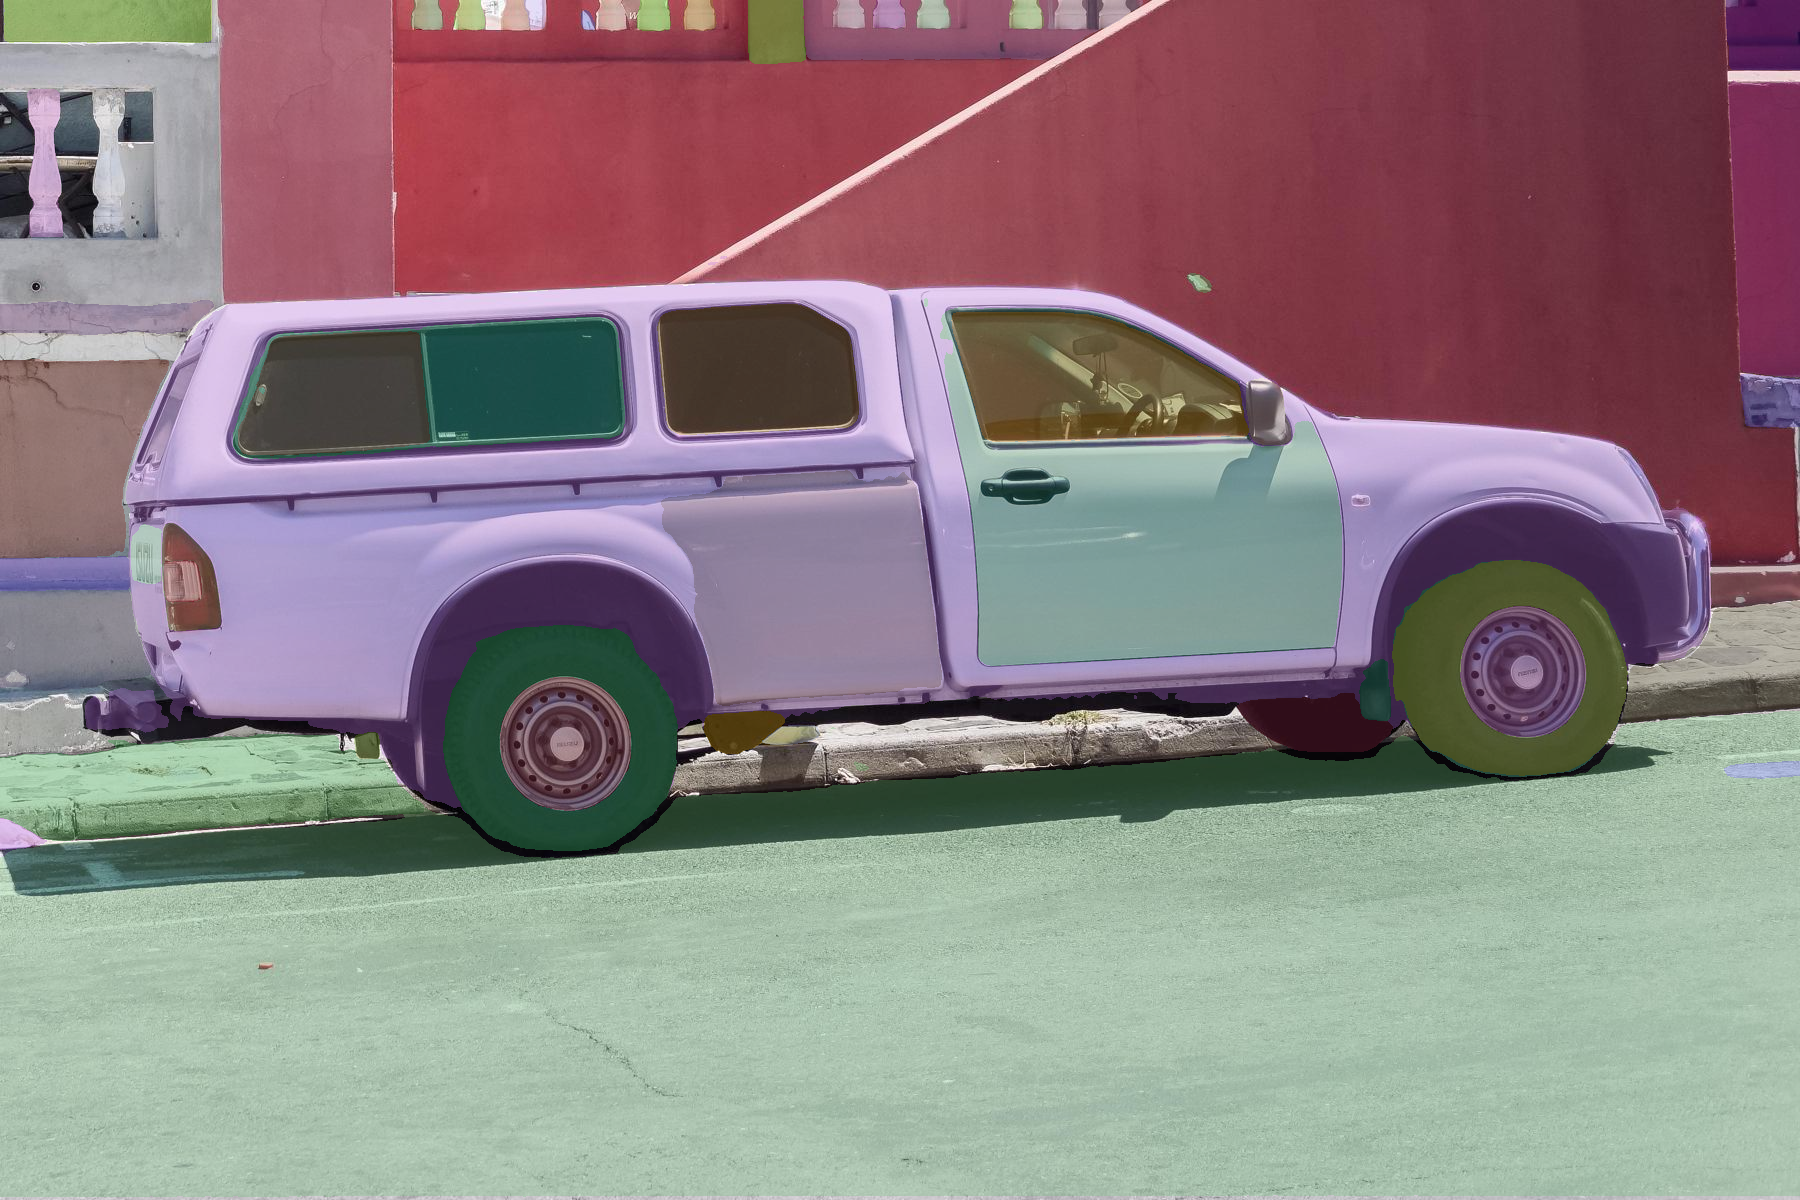

In [182]:
import PIL

out = draw_anns(image, prediction)
cv2.imwrite("result.png", out[:, :, ::-1])

PIL.Image.open("result.png")